In [377]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 


KeyboardInterrupt: 

In [721]:
from metaflow import Flow
flow = Flow('PrepareFeatures').latest_successful_run
raw_df = flow.data.clean_simple_features

In [722]:
raw_df['signal'].value_counts(normalize=True) * 100

1.0    72.775073
0.0    27.224927
Name: signal, dtype: float64

In [723]:
nouse_vec = 2
estimators = 50
k = 30

In [724]:
import xgboost as xgb


words = raw_df['word'].unique()
vector_list = [model[word] for word in words if word in model.vocab]
words_filtered = [word for word in words if word in model.vocab]
word_vec_zip = zip(words_filtered, vector_list)
word_vec_dict = dict(word_vec_zip)
df2 = pd.DataFrame.from_dict(word_vec_dict, orient='index')
# .set_index('word').join(df2, how='right').reset_index().rename(columns={'index': 'word'})

if nouse_vec == 1:
    df = raw_df.copy()
elif nouse_vec == 2:
    df = raw_df.copy().set_index('word')\
        .join(df2[[]], how='right').reset_index().rename(columns={'index': 'word'})
    df3 = raw_df[['word']].copy().set_index('word')\
        .join(df2, how='right').reset_index(drop=True)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df3)
    df = df.join(pd.get_dummies(kmeans.predict(df3)))
else:
    df = raw_df.copy().set_index('word')\
    .join(df2, how='right').reset_index().rename(columns={'index': 'word'})

df['userId'] = pd.get_dummies(df['userId'])

import pyphen

dic = pyphen.Pyphen(lang='en_US')

data_df = df
data_df['len'] = data_df['word'].map(lambda x: len(str(x)))
data_df['syl'] = data_df['word'].map(lambda x: len(dic.inserted(str(x)).split('-')))
data_df = data_df.iloc[:, df.columns != 'word']
y = 1 - data_df['signal']
x = data_df.iloc[:, data_df.columns != 'signal']
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 40)

model2 = xgb.XGBClassifier(n_estimators = 50, n_jobs=10)
model2.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=10, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [725]:
xgb_cv = xgb.XGBClassifier(n_estimators=50)
scores = cross_val_score(xgb_cv, x_train, y_train, cv=10, scoring = "precision")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.56060606 0.50549451 0.5        0.58823529 0.57142857 0.51315789
 0.6375     0.57352941 0.63934426 0.46969697]
Mean: 0.5558992970140384
Standard Deviation: 0.05492224478206299


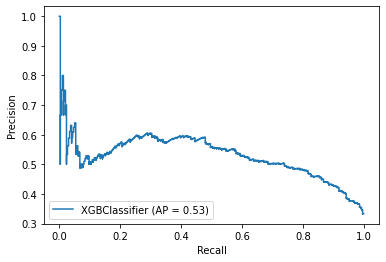

In [726]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model2, x_test, y_test)


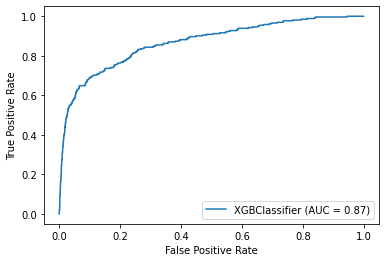

In [717]:
test_pred = model2.predict_proba(x_test)

metrics.plot_roc_curve(model2, x_test, y_test)

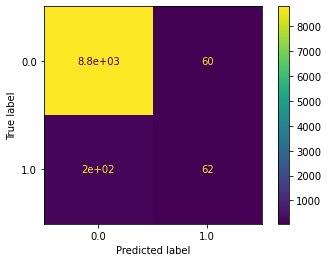

In [718]:
test_pred = model2.predict(x_test)

import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model2, x_test, y_test)